The code computes the timing of minima for eclipsing binaries based on user-provided ephemerides. This code is written for planning observation of The Eclipsing Binaries Minima (BIMA) 2.0 Monitoring Project.

- Code 1 is used when the initial epoch or last known time of minima in Heliocentric Julian Date (HJD)
- Code 2 is used when the initial epoch or last known time of minima in Julian Date (JD)

The code will compute next time of primary minima during any given observing time and create plot of simplified light curve (assumed as sinusoidal; the secondary minima is at phase 0.5 or shown as maxima on the graphs). The time of minima (primary minima) and maxima (secondary minima) are shown on the graphs.

The user need to input the object, location and time of observation. 
For example:

Enter binary star parameters:
Object ID (e.g., RT And): 
Right Ascension (hhmmss.sss format, e.g., 23h11m10.01s): 
Declination (ddmmss.sss format, e.g., 53d01m33.0s):  
Initial epoch (in HJD, e.g., 2452500.3476):  
Period (in days, e.g., 0.628929): 

Enter observer location:
Latitude (deg, -90 to 90 , e.g. -6.8245):  
Longitude (deg, -180 to 180, e.g. 107.6159):  
Altitude (m): 
Timezone offset (hrs from UTC, e.g., -4 for EDT): 

Enter observation window (local time):
Start (YYYYMMDD HHMM, e.g., 20240515 2100):  
End (YYYYMMDD HHMM, e.g., 20240516 0300): 

### 1. Calculate time of minima if the initial epoch in Heliocentric Julian Date (HJD)

Binary Star Ephemeris Calculator (HJD Input Version)

Enter binary star parameters:


Object ID (e.g., RT And):  RT And
Right Ascension (hhmmss.sss format, e.g., 23h11m10.01s):  23h11m10.01s
Declination (ddmmss.sss format, e.g., 53d01m33.0s):  53d01m33.0s
Initial epoch (HJD, e.g., 2452500.3476):  2452500.3476
Period (in days, e.g., 0.628929):  0.628929



Enter observer location:


Latitude (deg, -90 to 90, e.g. -6.8245):  -6.8245
Longitude (deg, -180 to 180, e.g. 107.6159):  107.6159
Altitude (m):  1310
Timezone offset (hours from UTC, e.g. 7 for Jakarta):  7



Enter observation window (local time):


Start (YYYYMMDD HHMM, e.g., 20240515 2100):  20240515 2100
End (YYYYMMDD HHMM, e.g., 20240516 0300):  20240516 0300



Calculated Minima:
Object: RT And
Coordinates: 23h11m10.01s +53d01m33s
Period: 0.628929 days
Initial epoch (HJD): 2452500.347600
Observation window: 2024-05-15T14:00:00.000 to 2024-05-15T20:00:00.000 UTC

 Epoch             JD            HJD          Local_Time
 12632 2460445.605731 2460445.608682 2024-05-15 09:32:15
 12633 2460446.234660 2460446.237589 2024-05-16 00:37:54

Results saved to RT_And_minima.csv


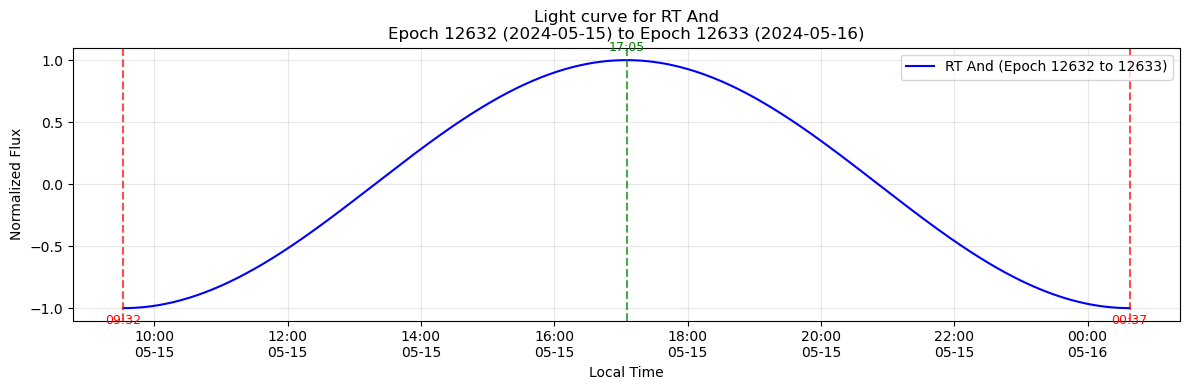

In [39]:
import pandas as pd
from astropy import time, coordinates as coord, units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import EarthLocation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter, HourLocator

def hjd_to_jd(hjd, tcoord, obs_location):
    """Convert HJD to JD with light-time correction"""
    t_hjd = Time(hjd, format='jd', scale='utc')
    ltt = t_hjd.light_travel_time(tcoord, 'heliocentric', location=obs_location)
    return (t_hjd - ltt).jd

def get_user_input():
    """Get user input for binary star parameters with proper validation."""
    print("Enter binary star parameters:")
    object_id = input("Object ID (e.g., RT And): ").strip()
    
    while True:
        try:
            ra_input = input("Right Ascension (hhmmss.sss format, e.g., 23h11m10.01s): ").strip()
            dec_input = input("Declination (ddmmss.sss format, e.g., 53d01m33.0s): ").strip()
            
            # Create SkyCoord with validation
            tcoord = coord.SkyCoord(ra_input, dec_input)
            break
        except ValueError as e:
            print(f"Error in coordinates: {e}")
            print("Please enter coordinates in the correct format.")
    
    while True:
        try:
            e0hjd = float(input("Initial epoch (HJD, e.g., 2452500.3476): "))
            break
        except ValueError:
            print("Please enter a valid number for the initial epoch.")
    
    while True:
        try:
            period = float(input("Period (in days, e.g., 0.628929): "))
            if period <= 0:
                raise ValueError("Period must be positive")
            break
        except ValueError as e:
            print(f"Invalid period: {e}")
    
    return {
        'id': object_id,
        'tcoord': tcoord,
        'e0_hjd': e0hjd,
        'period': period
    }

def get_observer_location():
    """Get observer location with validation."""
    print("\nEnter observer location:")
    while True:
        try:
            lat = float(input("Latitude (deg, -90 to 90, e.g. -6.8245): "))
            if not -90 <= lat <= 90:
                raise ValueError("Latitude must be between -90 and 90")
            lon = float(input("Longitude (deg, -180 to 180, e.g. 107.6159): "))
            if not -180 <= lon <= 180:
                raise ValueError("Longitude must be between -180 and 180")
            alt = float(input("Altitude (m): "))
            tz_offset = float(input("Timezone offset (hours from UTC, e.g. 7 for Jakarta): "))
            break
        except ValueError as e:
            print(f"Invalid input: {e}")
    
    return EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=alt*u.m), tz_offset

def get_observation_window(tz_offset):
    """Get observation window with validation."""
    print("\nEnter observation window (local time):")
    while True:
        try:
            start_str = input("Start (YYYYMMDD HHMM, e.g., 20240515 2100): ").strip()
            end_str = input("End (YYYYMMDD HHMM, e.g., 20240516 0300): ").strip()
            
            # Validate and parse dates
            if len(start_str) != 13 or len(end_str) != 13:
                raise ValueError("Date format must be YYYYMMDD HHMM")
            
            start_iso = f"{start_str[:4]}-{start_str[4:6]}-{start_str[6:8]}T{start_str[9:11]}:{start_str[11:13]}:00"
            end_iso = f"{end_str[:4]}-{end_str[4:6]}-{end_str[6:8]}T{end_str[9:11]}:{end_str[11:13]}:00"
            
            start_utc = Time(start_iso, format='isot', scale='utc') - TimeDelta(tz_offset*3600, format='sec')
            end_utc = Time(end_iso, format='isot', scale='utc') - TimeDelta(tz_offset*3600, format='sec')
            
            if end_utc <= start_utc:
                raise ValueError("End time must be after start time")
            
            return start_utc, end_utc
        except Exception as e:
            print(f"Error in dates: {e}")

def calculate_minima(results, obs_location, tz_offset, start_utc, end_utc):
    """Calculate all minima within observation window"""
    minima_data = []
    e0_jd = hjd_to_jd(results['e0_hjd'], results['tcoord'], obs_location)
    period = results['period']
    
    # Calculate first epoch in window
    ep_start = int((start_utc.jd - e0_jd) / period)
    tmin = e0_jd + max(0, ep_start) * period
    
    # Calculate all minima in window
    while tmin <= end_utc.jd:
        tmin_utc = Time(tmin, format='jd', scale='utc')
        tmin_local = tmin_utc.to_datetime() + pd.Timedelta(hours=tz_offset)
        epoch = int((tmin - e0_jd) / period)
        
        minima_data.append({
            'Object': results['id'],
            'Epoch': epoch,
            'JD': tmin,
            'HJD': hjd_to_jd(tmin, results['tcoord'], obs_location),
            'Local_Time': tmin_local.strftime('%Y-%m-%d %H:%M:%S'),
            'Period': period
        })
        tmin += period
        
    return pd.DataFrame(minima_data)

def plot_light_curves(minima_df, tz_offset):
    """Generate plots with correct phase alignment and local time display"""
    if minima_df.empty:
        print("No minima found to plot!")
        return
    
    for (obj, group) in minima_df.groupby('Object'):
        if len(group) < 2:
            print(f"Warning: Only one minimum found for {obj}, cannot plot light curve")
            continue
            
        # Create plots for each pair of minima
        for i in range(len(group) - 1):
            row1 = group.iloc[i]
            row2 = group.iloc[i + 1]
            
            # Create figure with proper sizing
            fig, ax = plt.subplots(figsize=(12, 4))
            
            # Generate light curve data between two minima
            jd_range = np.linspace(row1['JD'], row2['JD'], 500)
            period = row1['Period']
            
            # Calculate phase (0 at first minimum, 1 at next minimum)
            phases = ((jd_range - row1['JD']) / period) % 1
            
            # Create light curve with minima at y=-1 (phases 0 and 1) 
            # and maxima at y=1 (phase 0.5)
            flux = -np.cos(2 * np.pi * phases)
            
            # Convert to local datetime for plotting
            times = [Time(jd, format='jd').to_datetime() + pd.Timedelta(hours=tz_offset) 
                      for jd in jd_range]
            
            # Plot main curve
            ax.plot(times, flux, 'b-', label=f"{obj} (Epoch {row1['Epoch']} to {row2['Epoch']})")
            
            # Mark minima (y=-1)
            min1_time = Time(row1['JD'], format='jd').to_datetime() + pd.Timedelta(hours=tz_offset)
            min2_time = Time(row2['JD'], format='jd').to_datetime() + pd.Timedelta(hours=tz_offset)
            
            ax.axvline(x=min1_time, color='r', linestyle='--', alpha=0.7)
            ax.text(min1_time, -1.05, min1_time.strftime('%H:%M'),
                   ha='center', va='top', color='r', fontsize=9)
            
            ax.axvline(x=min2_time, color='r', linestyle='--', alpha=0.7)
            ax.text(min2_time, -1.05, min2_time.strftime('%H:%M'),
                   ha='center', va='top', color='r', fontsize=9)
            
            # Mark maxima (y=1)
            max_time = Time(row1['JD'] + period/2, format='jd').to_datetime() + pd.Timedelta(hours=tz_offset)
            ax.axvline(x=max_time, color='g', linestyle='--', alpha=0.7)
            ax.text(max_time, 1.05, max_time.strftime('%H:%M'),
                   ha='center', va='bottom', color='g', fontsize=9)
            
            # Format plot
            date1 = min1_time.strftime('%Y-%m-%d')
            date2 = min2_time.strftime('%Y-%m-%d')
            ax.set_title(f"Light curve for {obj}\nEpoch {row1['Epoch']} ({date1}) to Epoch {row2['Epoch']} ({date2})",
                        fontsize=12)
            ax.set_xlabel("Local Time", fontsize=10)
            ax.set_ylabel("Normalized Flux", fontsize=10)
            
            # Set y-axis limits and ticks
            ax.set_ylim(-1.1, 1.1)
            ax.set_yticks([-1, -0.5, 0, 0.5, 1])
            
            # Set x-axis ticks and format
            ax.xaxis.set_major_locator(HourLocator(interval=2))
            ax.xaxis.set_major_formatter(DateFormatter('%H:%M\n%m-%d'))
            
            ax.grid(True, alpha=0.3)
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()

def main():
    print("Binary Star Ephemeris Calculator (HJD Input Version)")
    print("===================================================\n")
    
    # Get all required inputs
    results = get_user_input()
    obs_location, tz_offset = get_observer_location()
    start_utc, end_utc = get_observation_window(tz_offset)
    
    # Calculate minima (with HJD to JD conversion)
    minima_df = calculate_minima(results, obs_location, tz_offset, start_utc, end_utc)
    
    if minima_df.empty:
        print("\nNo minima found in the specified observation window!")
        print(f"Window: {start_utc.isot} to {end_utc.isot} UTC")
        return
    
    # Display results
    print("\nCalculated Minima:")
    print("=================")
    print(f"Object: {results['id']}")
    print(f"Coordinates: {results['tcoord'].to_string('hmsdms')}")
    print(f"Period: {results['period']:.6f} days")
    print(f"Initial epoch (HJD): {results['e0_hjd']:.6f}")
    print(f"Observation window: {start_utc.isot} to {end_utc.isot} UTC\n")
    
    # Print table of minima
    with pd.option_context('display.float_format', '{:.6f}'.format):
        print(minima_df[['Epoch', 'JD', 'HJD', 'Local_Time']].to_string(index=False))
    
    # Save results
    minima_df.to_csv(f"{results['id'].replace(' ', '_')}_minima.csv", index=False)
    print(f"\nResults saved to {results['id'].replace(' ', '_')}_minima.csv")
    
    # Plot light curves
    plot_light_curves(minima_df, tz_offset)

if __name__ == "__main__":
    main()


### 2. Calculate time of minima if the initial epoch in Julian Date (JD)

Binary Star Ephemeris Calculator

Enter binary star parameters:


Object ID (e.g., RT And):  RT And
Right Ascension (hhmmss.sss format, e.g., 23h11m10.01s):  23h11m10.01s
Declination (ddmmss.sss format, e.g., 53d01m33.0s):  53d01m33.0s
Initial epoch (JD, e.g., 2452500.3476):  2452500.3476
Period (in days, e.g., 0.628929):  0.628929



Enter observer location:


Latitude (deg, -90 to 90, e.g. -6.8245):  -6.8245
Longitude (deg, -180 to 180, e.g. 107.6159):  107.6159
Altitude (m):  1310
Timezone offset (hours from UTC, e.g. 7 for Jakarta):  7



Enter observation window (local time):


Start (YYYYMMDD HHMM, e.g., 20240515 2100):  20250620 1100
End (YYYYMMDD HHMM, e.g., 20240516 0300):  20250624 0500



Calculated Minima:
Object: RT And
Coordinates: 23h11m10.01s +53d01m33s
Period: 0.628929 days
Initial epoch: 2452500.347600 JD
Observation window: 2025-06-20T04:00:00.000 to 2025-06-23T22:00:00.000 UTC

 Epoch             JD          Local_Time
 13269 2460846.235430 2025-06-20 00:39:01
 13270 2460846.864359 2025-06-20 15:44:40
 13271 2460847.493288 2025-06-21 06:50:20
 13272 2460848.122217 2025-06-21 21:55:59
 13273 2460848.751146 2025-06-22 13:01:39
 13274 2460849.380075 2025-06-23 04:07:18
 13275 2460850.009004 2025-06-23 19:12:57

Results saved to RT_And_minima.csv


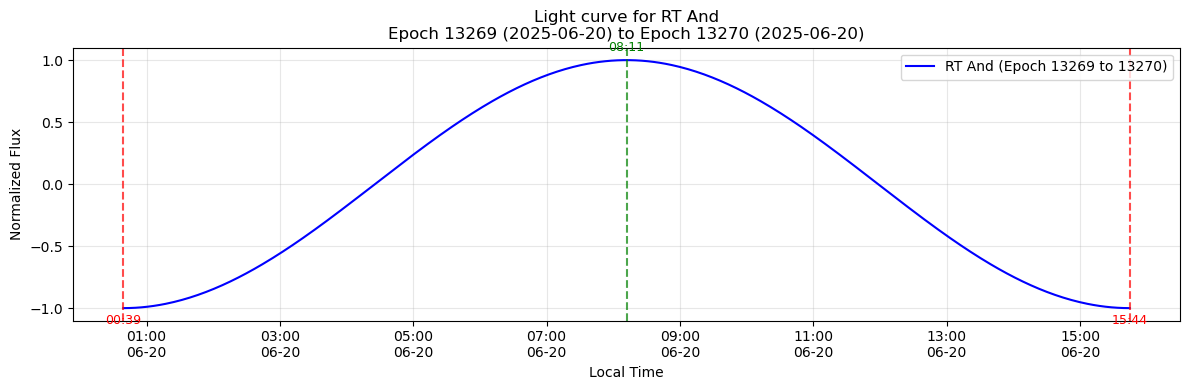

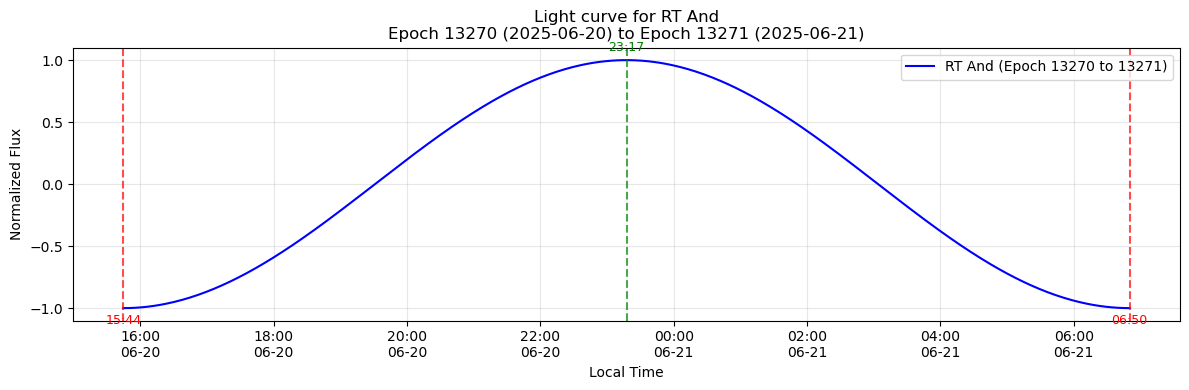

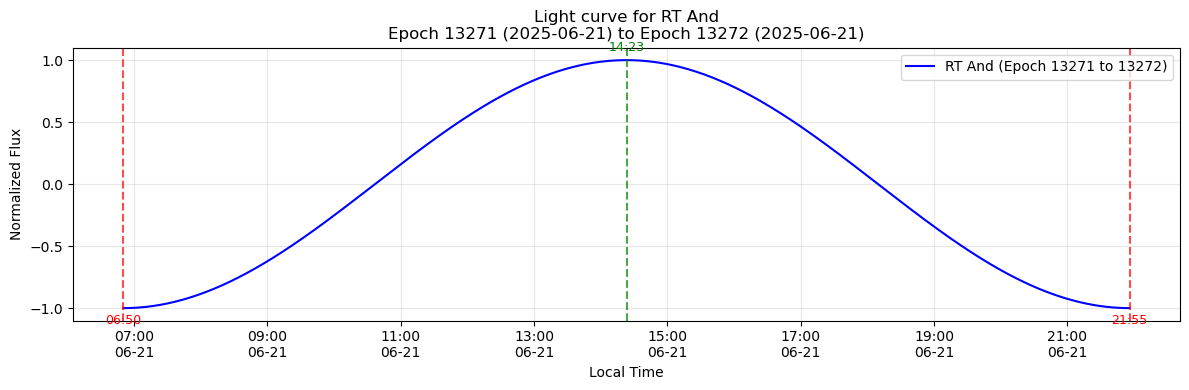

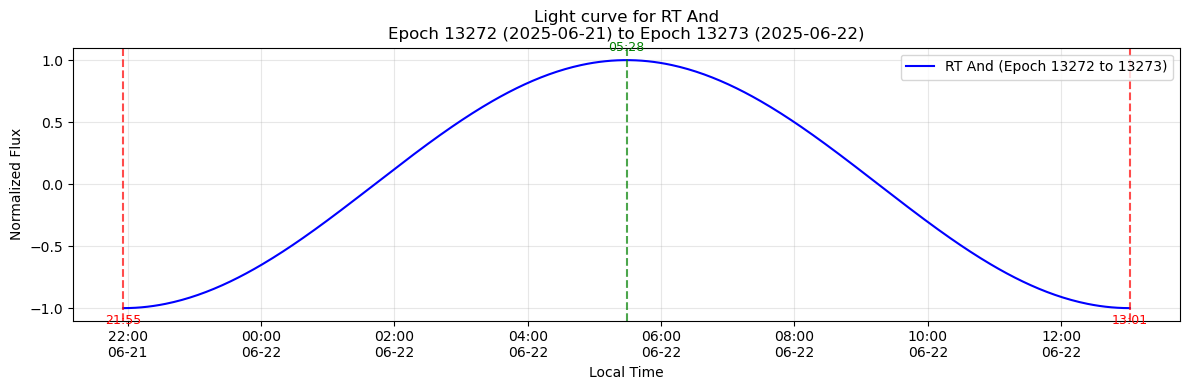

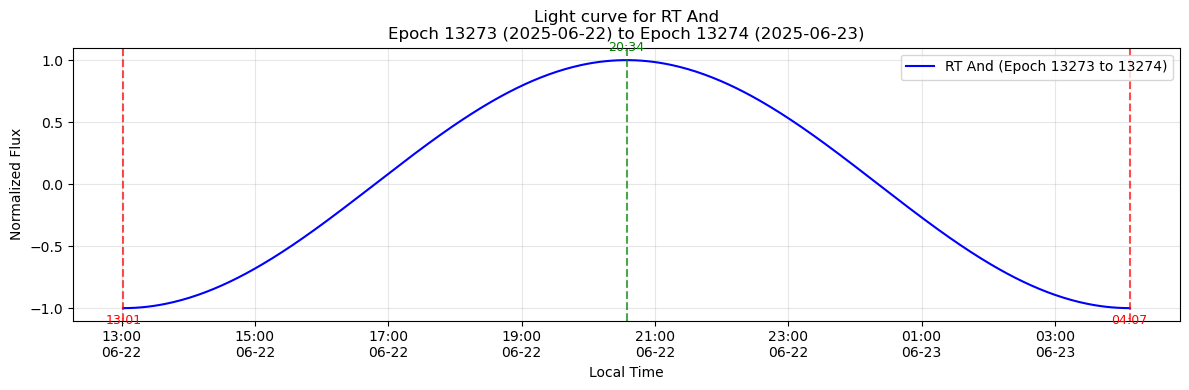

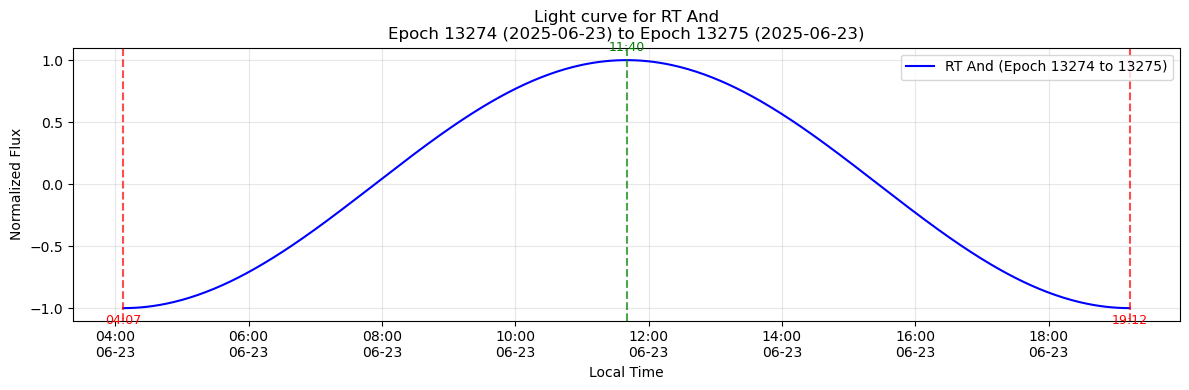

In [37]:
import pandas as pd
from astropy import time, coordinates as coord, units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import EarthLocation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter, HourLocator

def get_user_input():
    """Get user input for binary star parameters with proper validation."""
    print("Enter binary star parameters:")
    object_id = input("Object ID (e.g., RT And): ").strip()
    
    while True:
        try:
            ra_input = input("Right Ascension (hhmmss.sss format, e.g., 23h11m10.01s): ").strip()
            dec_input = input("Declination (ddmmss.sss format, e.g., 53d01m33.0s): ").strip()
            
            # Create SkyCoord with validation
            tcoord = coord.SkyCoord(ra_input, dec_input)
            break
        except ValueError as e:
            print(f"Error in coordinates: {e}")
            print("Please enter coordinates in the correct format.")
    
    while True:
        try:
            e0jd = float(input("Initial epoch (JD, e.g., 2452500.3476): "))
            break
        except ValueError:
            print("Please enter a valid number for the initial epoch.")
    
    while True:
        try:
            period = float(input("Period (in days, e.g., 0.628929): "))
            if period <= 0:
                raise ValueError("Period must be positive")
            break
        except ValueError as e:
            print(f"Invalid period: {e}")
    
    return {
        'id': object_id,
        'tcoord': tcoord,
        'e0_jd': e0jd,
        'period': period
    }

def get_observer_location():
    """Get observer location with validation."""
    print("\nEnter observer location:")
    while True:
        try:
            lat = float(input("Latitude (deg, -90 to 90, e.g. -6.8245): "))
            if not -90 <= lat <= 90:
                raise ValueError("Latitude must be between -90 and 90")
            lon = float(input("Longitude (deg, -180 to 180, e.g. 107.6159): "))
            if not -180 <= lon <= 180:
                raise ValueError("Longitude must be between -180 and 180")
            alt = float(input("Altitude (m): "))
            tz_offset = float(input("Timezone offset (hours from UTC, e.g. 7 for Jakarta): "))
            break
        except ValueError as e:
            print(f"Invalid input: {e}")
    
    return EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=alt*u.m), tz_offset

def get_observation_window(tz_offset):
    """Get observation window with validation."""
    print("\nEnter observation window (local time):")
    while True:
        try:
            start_str = input("Start (YYYYMMDD HHMM, e.g., 20240515 2100): ").strip()
            end_str = input("End (YYYYMMDD HHMM, e.g., 20240516 0300): ").strip()
            
            # Validate and parse dates
            if len(start_str) != 13 or len(end_str) != 13:
                raise ValueError("Date format must be YYYYMMDD HHMM")
            
            start_iso = f"{start_str[:4]}-{start_str[4:6]}-{start_str[6:8]}T{start_str[9:11]}:{start_str[11:13]}:00"
            end_iso = f"{end_str[:4]}-{end_str[4:6]}-{end_str[6:8]}T{end_str[9:11]}:{end_str[11:13]}:00"
            
            start_utc = Time(start_iso, format='isot', scale='utc') - TimeDelta(tz_offset*3600, format='sec')
            end_utc = Time(end_iso, format='isot', scale='utc') - TimeDelta(tz_offset*3600, format='sec')
            
            if end_utc <= start_utc:
                raise ValueError("End time must be after start time")
            
            return start_utc, end_utc
        except Exception as e:
            print(f"Error in dates: {e}")

def calculate_minima(results, tz_offset, start_utc, end_utc):
    """Calculate all minima within observation window"""
    minima_data = []
    e0_jd = results['e0_jd']
    period = results['period']
    
    # Calculate first epoch in window
    ep_start = int((start_utc.jd - e0_jd) / period)
    tmin = e0_jd + max(0, ep_start) * period
    
    # Calculate all minima in window
    while tmin <= end_utc.jd:
        tmin_utc = Time(tmin, format='jd', scale='utc')
        tmin_local = tmin_utc.to_datetime() + pd.Timedelta(hours=tz_offset)
        epoch = int((tmin - e0_jd) / period)
        
        minima_data.append({
            'Object': results['id'],
            'Epoch': epoch,
            'JD': tmin,
            'Local_Time': tmin_local.strftime('%Y-%m-%d %H:%M:%S'),
            'Period': period
        })
        tmin += period
        
    return pd.DataFrame(minima_data)

def plot_light_curves(minima_df, tz_offset):
    """Generate separate plots for each pair of minima"""
    if minima_df.empty:
        print("No minima found to plot!")
        return
    
    for (obj, group) in minima_df.groupby('Object'):
        if len(group) < 2:
            print(f"Warning: Only one minimum found for {obj}, cannot plot light curve")
            continue
            
        # Create plots for each pair of minima
        for i in range(len(group) - 1):
            row1 = group.iloc[i]
            row2 = group.iloc[i + 1]
            
            # Create figure with proper sizing
            fig, ax = plt.subplots(figsize=(12, 4))
            
            # Generate light curve data between two minima
            jd_range = np.linspace(row1['JD'], row2['JD'], 500)
            period = row1['Period']
            
            # Calculate phase (0 at first minimum, 1 at next minimum)
            phases = ((jd_range - row1['JD']) / period) % 1
            
            # Create light curve with minima at y=-1 (phases 0 and 1) 
            # and maxima at y=1 (phase 0.5)
            flux = -np.cos(2 * np.pi * phases)
            
            # Convert to local datetime for plotting
            times = [Time(jd, format='jd').to_datetime() + pd.Timedelta(hours=tz_offset) 
                      for jd in jd_range]
            
            # Plot main curve
            ax.plot(times, flux, 'b-', label=f"{obj} (Epoch {row1['Epoch']} to {row2['Epoch']})")
            
            # Mark minima (y=-1)
            min1_time = Time(row1['JD'], format='jd').to_datetime() + pd.Timedelta(hours=tz_offset)
            min2_time = Time(row2['JD'], format='jd').to_datetime() + pd.Timedelta(hours=tz_offset)
            
            ax.axvline(x=min1_time, color='r', linestyle='--', alpha=0.7)
            ax.text(min1_time, -1.05, min1_time.strftime('%H:%M'),
                   ha='center', va='top', color='r', fontsize=9)
            
            ax.axvline(x=min2_time, color='r', linestyle='--', alpha=0.7)
            ax.text(min2_time, -1.05, min2_time.strftime('%H:%M'),
                   ha='center', va='top', color='r', fontsize=9)
            
            # Mark maxima (y=1)
            max_time = Time(row1['JD'] + period/2, format='jd').to_datetime() + pd.Timedelta(hours=tz_offset)
            ax.axvline(x=max_time, color='g', linestyle='--', alpha=0.7)
            ax.text(max_time, 1.05, max_time.strftime('%H:%M'),
                   ha='center', va='bottom', color='g', fontsize=9)
            
            # Format plot
            date1 = min1_time.strftime('%Y-%m-%d')
            date2 = min2_time.strftime('%Y-%m-%d')
            ax.set_title(f"Light curve for {obj}\nEpoch {row1['Epoch']} ({date1}) to Epoch {row2['Epoch']} ({date2})",
                        fontsize=12)
            ax.set_xlabel("Local Time", fontsize=10)
            ax.set_ylabel("Normalized Flux", fontsize=10)
            
            # Set y-axis limits and ticks
            ax.set_ylim(-1.1, 1.1)
            ax.set_yticks([-1, -0.5, 0, 0.5, 1])
            
            # Set x-axis ticks and format
            ax.xaxis.set_major_locator(HourLocator(interval=2))
            ax.xaxis.set_major_formatter(DateFormatter('%H:%M\n%m-%d'))
            
            ax.grid(True, alpha=0.3)
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()

def main():
    print("Binary Star Ephemeris Calculator")
    print("===============================\n")
    
    # Get all required inputs
    results = get_user_input()
    obs_location, tz_offset = get_observer_location()
    start_utc, end_utc = get_observation_window(tz_offset)
    
    # Calculate minima
    minima_df = calculate_minima(results, tz_offset, start_utc, end_utc)
    
    if minima_df.empty:
        print("\nNo minima found in the specified observation window!")
        print(f"Window: {start_utc.isot} to {end_utc.isot} UTC")
        return
    
    # Display results
    print("\nCalculated Minima:")
    print("=================")
    print(f"Object: {results['id']}")
    print(f"Coordinates: {results['tcoord'].to_string('hmsdms')}")
    print(f"Period: {results['period']:.6f} days")
    print(f"Initial epoch: {results['e0_jd']:.6f} JD")
    print(f"Observation window: {start_utc.isot} to {end_utc.isot} UTC\n")
    
    # Print table of minima
    with pd.option_context('display.float_format', '{:.6f}'.format):
        print(minima_df[['Epoch', 'JD', 'Local_Time']].to_string(index=False))
    
    # Save results
    minima_df.to_csv(f"{results['id'].replace(' ', '_')}_minima.csv", index=False)
    print(f"\nResults saved to {results['id'].replace(' ', '_')}_minima.csv")
    
    # Plot light curves
    plot_light_curves(minima_df, tz_offset)

if __name__ == "__main__":
    main()
